# Homework 8: Clustering

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

## Mall Customers Dataset

In this assignment, you will work on customer segmentation using clustering techniques.

The dataset for this assignment is the **Mall Customers Dataset**, which contains customer data collected from a shopping mall. It includes:

- **CustomerID**: Unique identifier for each customer (not useful for clustering).
- **Gender**: Male or Female.
- **Age**: Age of the customer.
- **Annual Income (k$)**: Annual income in thousands of dollars.
- **Spending Score (1-100)**: A metric indicating customer spending habits.

The goal is to segment customers based on their characteristics using different clustering methods.


In [1]:
# Install yellowbricks if you don't already have it or are in colab
!pip install yellowbrick

In [2]:
import numpy as np
import polars as pl
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# Uncomment the line below if you are using Google colab
!gdown https://drive.google.com/uc?id=1Jo9YoLfvey-y6hIQK_pii-XUCJNAE_TE

Downloading...
From: https://drive.google.com/uc?id=1Jo9YoLfvey-y6hIQK_pii-XUCJNAE_TE
To: /content/Mall_Customers.csv
100% 4.29k/4.29k [00:00<00:00, 10.0MB/s]


1. Load the CSV file. Display the summary statistics for the dataset and check if there are any null values in the dataset. Use polars unless your operators do not allow it (transforming them to pandas or numpy at that stage).

In [4]:
# YOUR CODE HERE
# Load Dataset
data = pl.read_csv("Mall_Customers.csv")
# Summary Statistics
data.describe()

statistic,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
str,f64,str,f64,f64,f64
"""count""",200.0,"""200""",200.0,200.0,200.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",100.5,null,38.85,60.56,50.2
"""std""",57.879185,null,13.969007,26.264721,25.823522
"""min""",1.0,"""Female""",18.0,15.0,1.0
"""25%""",51.0,null,29.0,42.0,35.0
"""50%""",101.0,null,36.0,62.0,50.0
"""75%""",150.0,null,49.0,78.0,73.0
"""max""",200.0,"""Male""",70.0,137.0,99.0


In [5]:
# YOUR CODE HERE
# Check for null values
data.null_count()

CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
u32,u32,u32,u32,u32
0,0,0,0,0


2. For the clustering analyses, consider only the numerical variables. Therefore you should drop 'Genre' from the dataset. Standardize the remaining variables, excluding the ID, ensuring they have mean of zero and standard deviation of one.

In the following lines you should:

- Update the dataset to include only numerical features and display the first 10 rows of the updated dataset.

- Standardize the features.

In [6]:
# YOUR CODE HERE
# Drop 'Genre' from the dataset.
data = data.drop("Genre")
data.head(10)

CustomerID,Age,Annual Income (k$),Spending Score (1-100)
i64,i64,i64,i64
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
6,22,17,76
7,35,18,6
8,23,18,94
9,64,19,3


In [7]:
# YOUR CODE HERE
# Standarisation excluding ID column
scaler = StandardScaler()
numeric_features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [8]:
data.describe()

statistic,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
str,f64,f64,f64,f64
"""count""",200.0,200.0,200.0,200.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",100.5,-6.3949e-16,-1.4211e-16,-2.1316e-16
"""std""",57.879185,1.002509,1.002509,1.002509
"""min""",1.0,-1.496335,-1.738999,-1.910021
"""25%""",51.0,-0.706902,-0.708425,-0.590088
"""50%""",101.0,-0.204535,0.054964,-0.007764
"""75%""",150.0,0.728432,0.665675,0.885132
"""max""",200.0,2.235532,2.917671,1.894492


## K-means

3. Use the K-means method to perform clustering on the scaled data from Q2, setting `random_state = 2025`. Determine the optimal number of clusters using the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)  function with `k=(2,12)`.



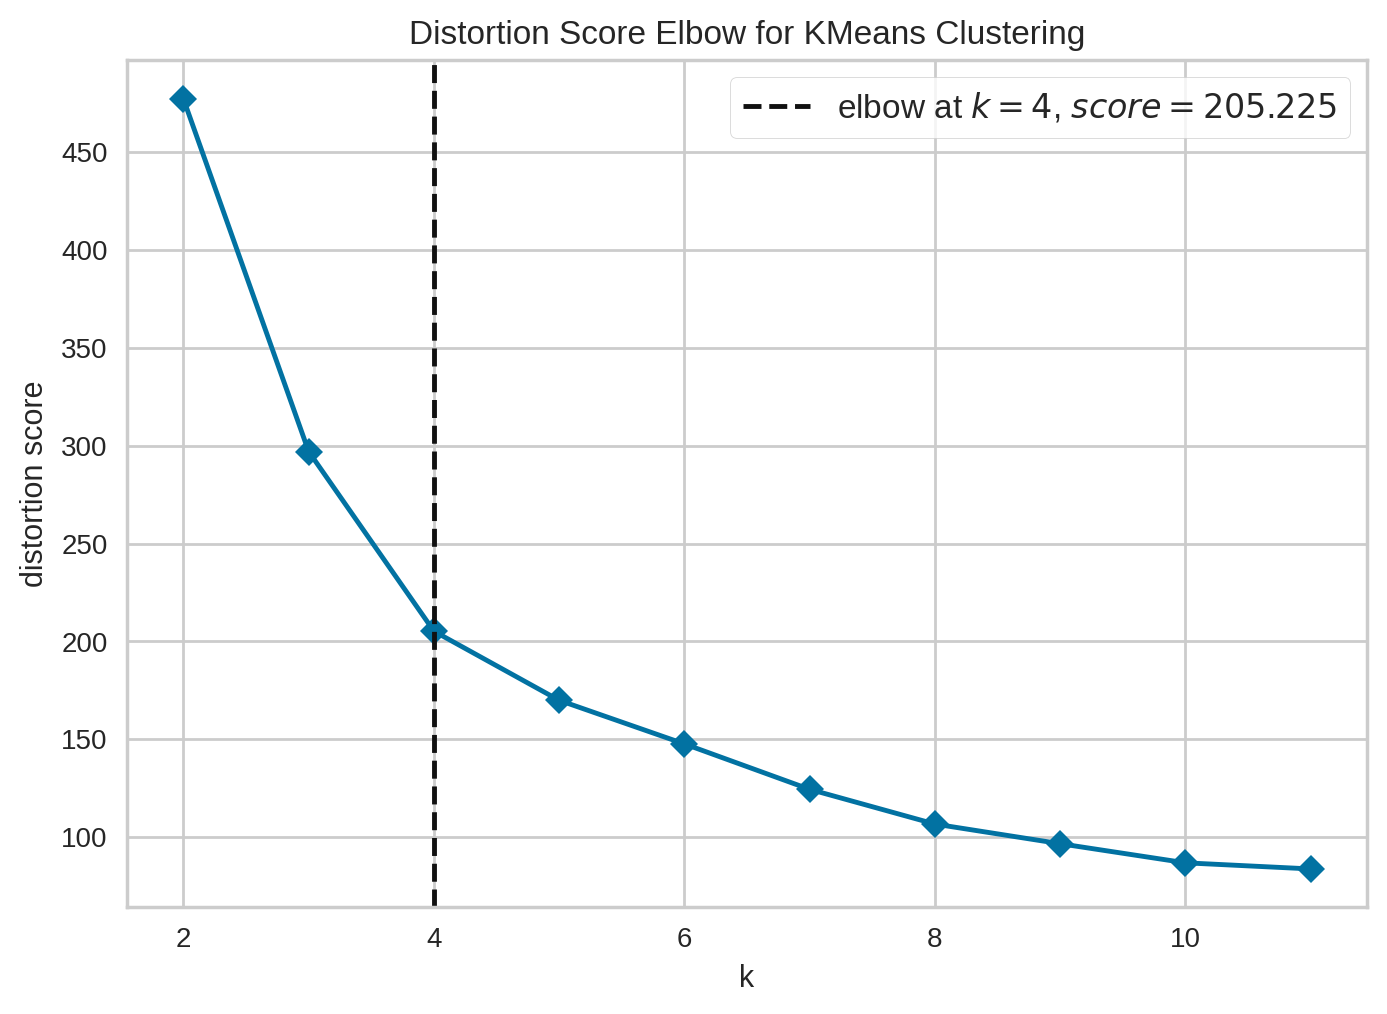

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# YOUR CODE HERE
KClusterer = KMeans(random_state=2025)
visualizer = KElbowVisualizer(KClusterer,     # Cluster model with any parameters you need
                k=(2,12),      # Number of clusters to test (2 to 12 in this case)
                locate_elbow=True,  # Locate the elbow? Default is true.
                timings=False    # Plot the timings to train?
                )

# Convert the Polars DataFrame to a Pandas DataFrame before fitting the visualizer
visualizer.fit(data[numeric_features].to_pandas())        # Fit the data to the visualizer
visualizer.show()


**Written answer: What is the optimal number of clusters using the elbow method?**

**ANSWER HERE:**

From the results above, the optimal number of clusters is 4.

4. Fit a K-means model on the scaled data using the optimal number of clusters identified in Q3. Then, visualize the resulting clusters using a scatterplot matrix (`sns.pairplot`).

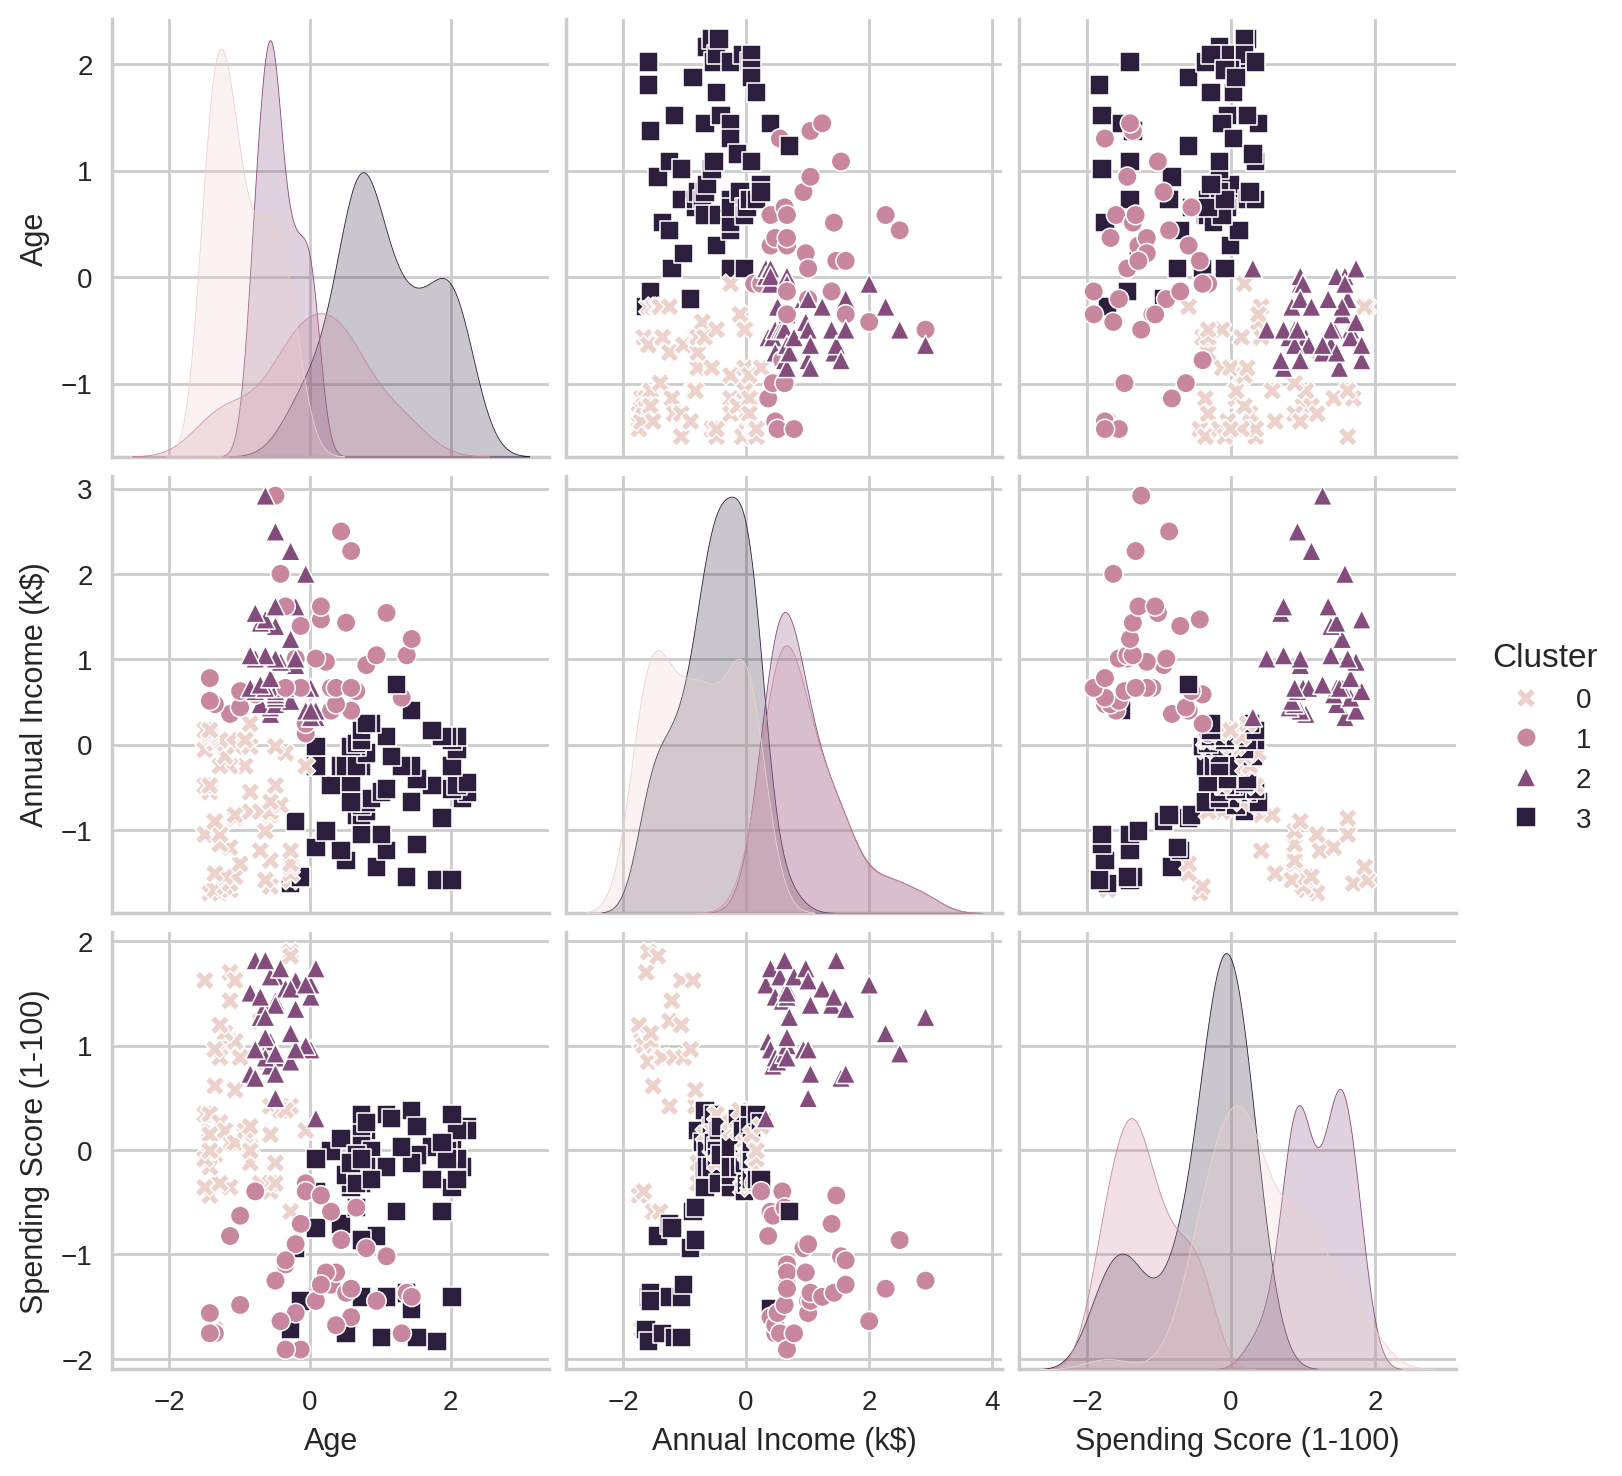

In [10]:
# YOUR CODE HERE
kmeans_4 = KMeans(n_clusters=4, random_state=2025)
kmeans_4.fit((data[numeric_features]))

# Adding cluster labels
data = data.with_columns(pl.Series(name="Cluster", values=kmeans_4.labels_))

# Visualisation
sns.pairplot(data.to_pandas(),  # Convert to pandas DataFrame
      vars=["Age", "Annual Income (k$)", "Spending Score (1-100)"],
      hue="Cluster",
      markers=['X','o','^','s'],
      diag_kind="kde",
      height=2.5
      )
plt.show()

5. The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the clusters from Q4, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster by analyzing their defining features, such as whether they represent high-income spenders, budget-conscious customers, or younger versus older groups.

In [11]:
# YOUR CODE HERE
unscaled_data = pl.read_csv("Mall_Customers.csv").drop("Genre").with_columns(pl.Series(name="Cluster", values=kmeans_4.labels_))
unscaled_data.to_pandas().groupby("Cluster").mean()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,,
0,53.438596,25.438596,40.000000,60.298246
1,160.552632,39.368421,86.500000,19.578947
2,161.025000,32.875000,86.100000,81.525000
3,69.415385,53.984615,47.707692,39.969231


**Written answer:**

- Cluster 0: Young, lower-income, mid-to-high spenders
  -  These are younger shoppers who have relativey low income levels but spend relatively more. Likely impulsive buyers or those influenced by trends. Potentially responsive to promotions and loyalty programs.

- Cluster 1: Middle-aged, high-income, low spenders
  - These are the customers that have significant purchasing power but show conservative spending behavior. They may need premium value propositions or trust-building incentives to increase spending.

- Cluster 2: Young-to-middle-aged, high-income, high spenders
  - This is the most profitable group becasue they have both high income and high spending scores. These customers can be targeted with luxury products, exclusive membership programs, and personalized services

- Cluster 3: Older, middle-income, low-to-mid spenders
  - These customers are likely to be more budget-conscious or conservative shoppers who prefer reliability and value for money. They may respond well to senior discounts, loyalty rewards, and trust-based marketing.

## Agglomerative clustering

6. Use Agglomerative Clustering with `linkage='average'` to determine the best number of clusters (between 3 and 7) using silhouette analysis.

For each number of clusters:

- Compute and print the average silhouette score.
- Generate and display a silhouette plot.

Number of clusters: 3, Average silhouette score: 0.3400


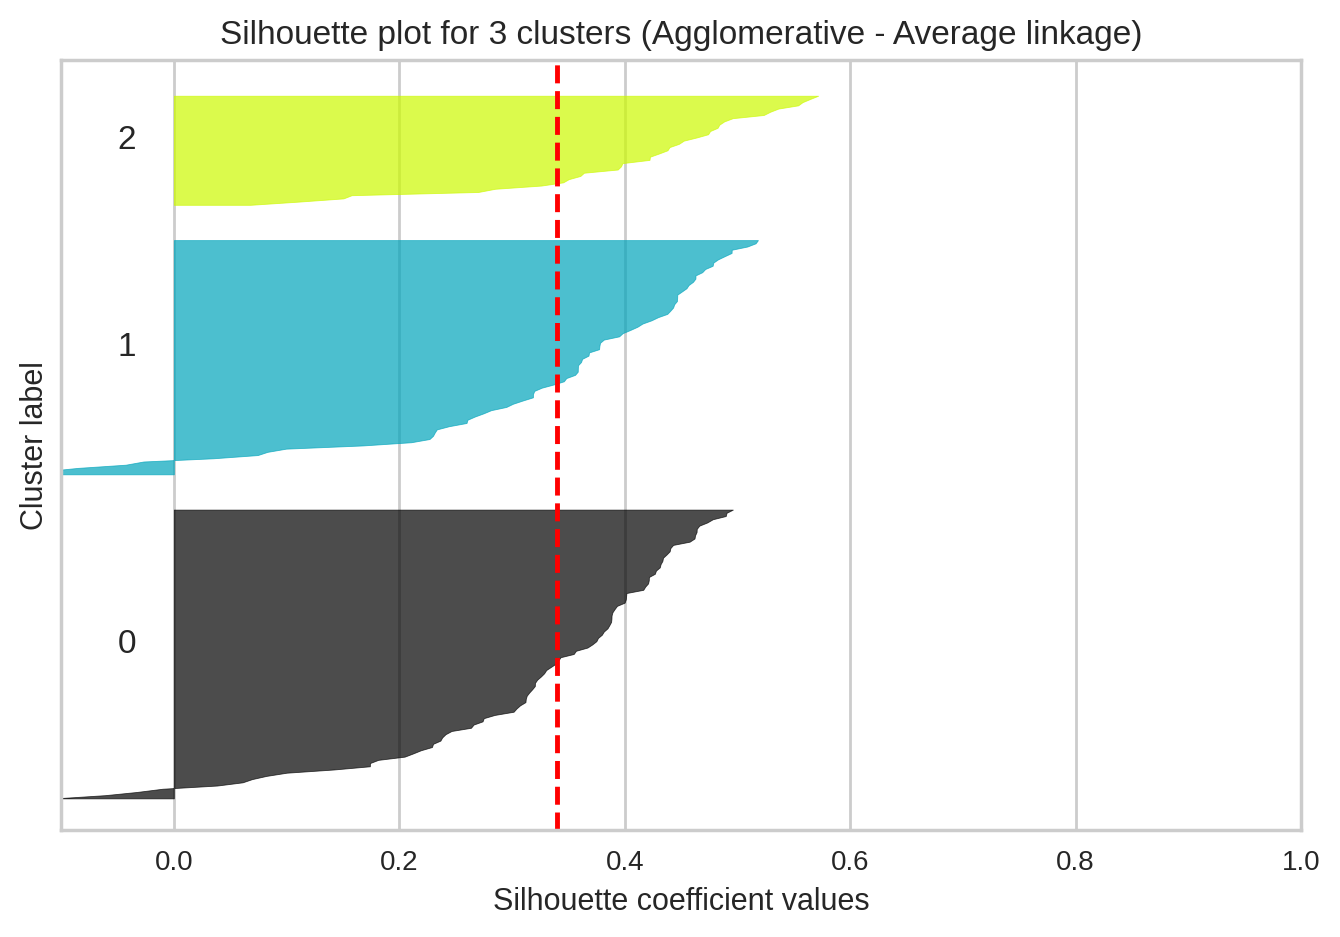

Number of clusters: 4, Average silhouette score: 0.3839


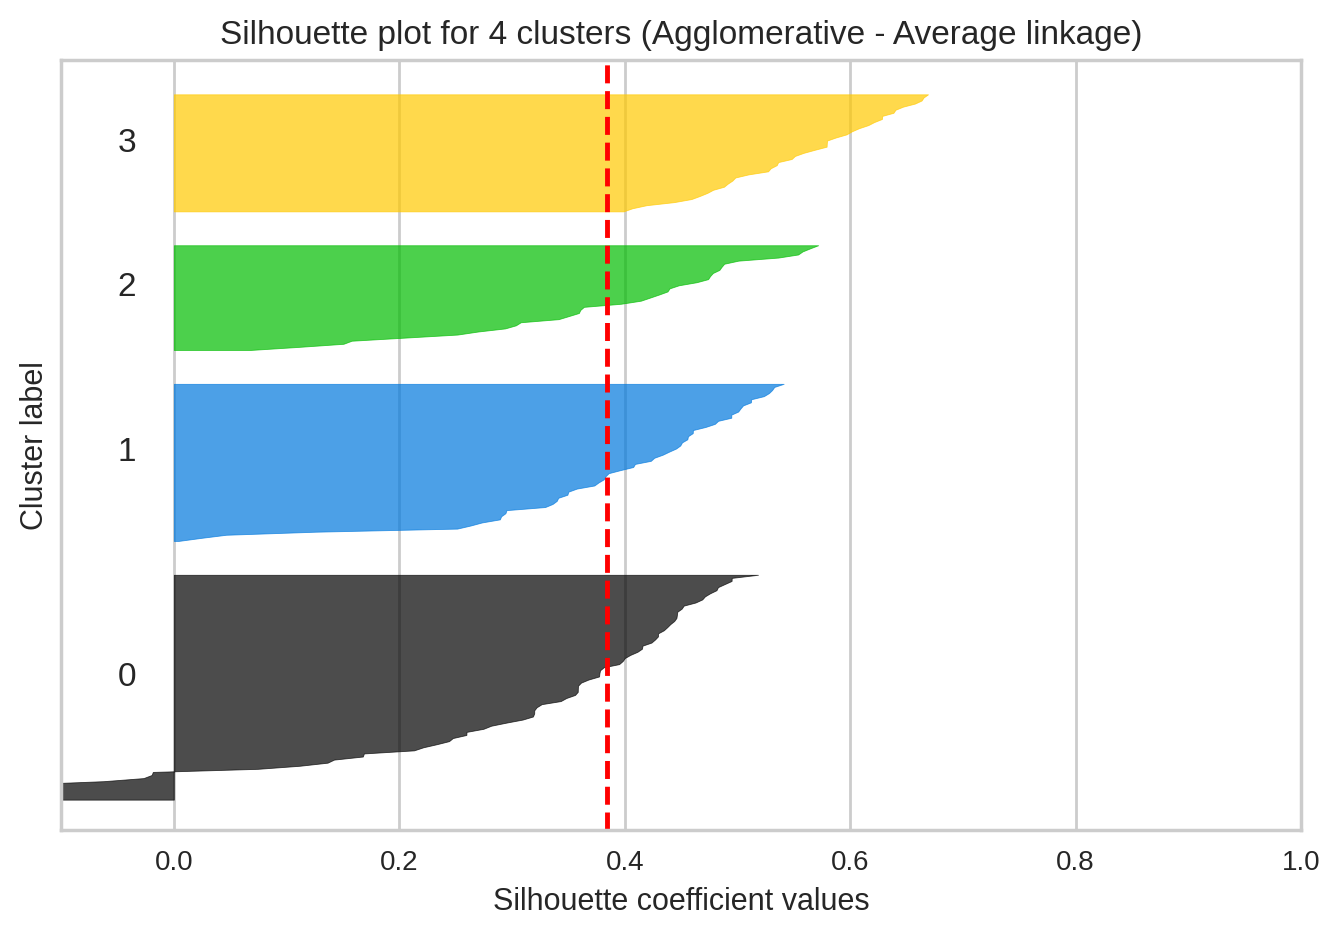

Number of clusters: 5, Average silhouette score: 0.4096


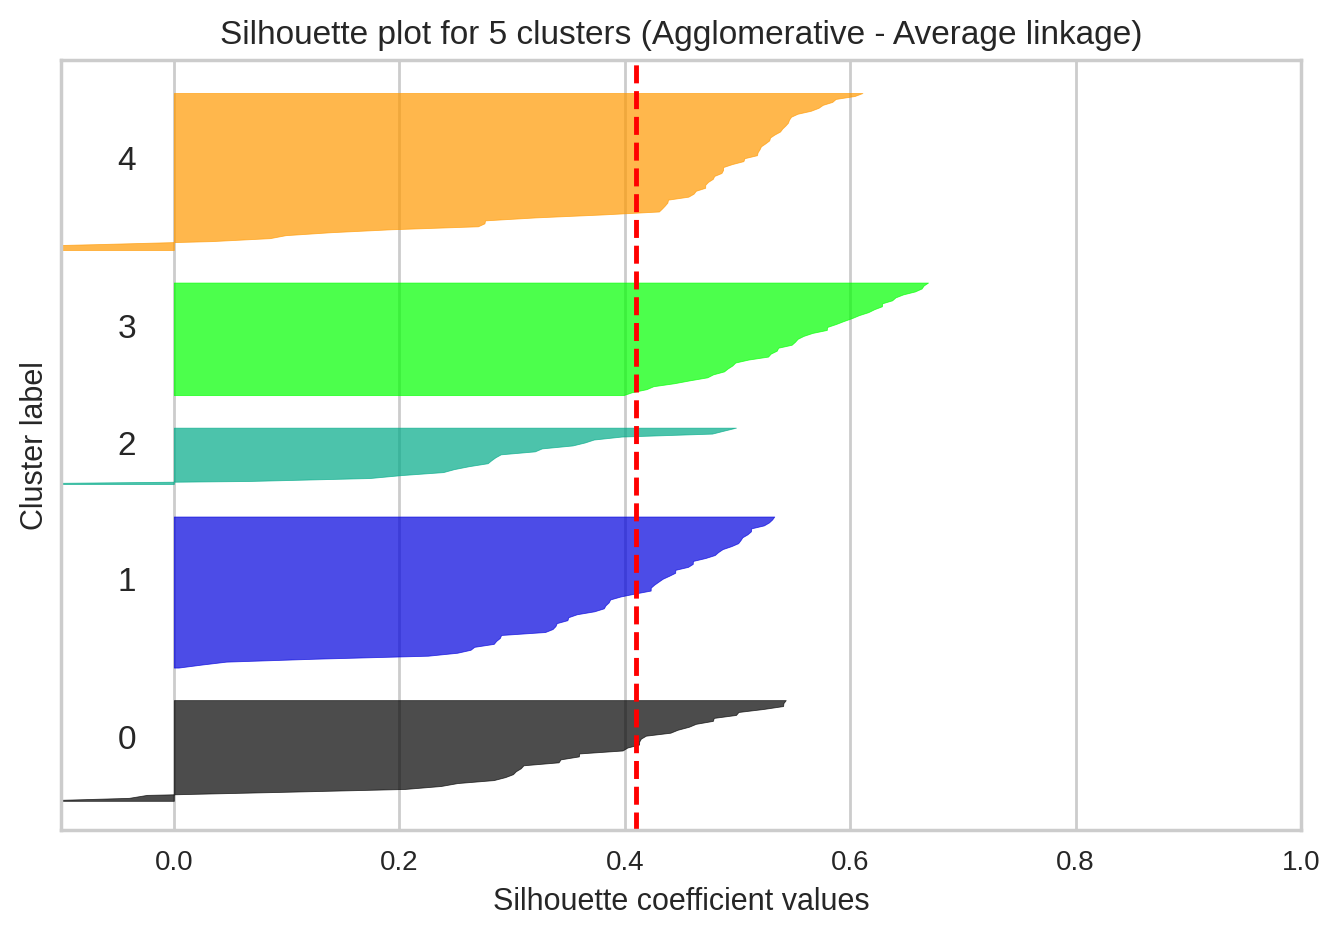

Number of clusters: 6, Average silhouette score: 0.3896


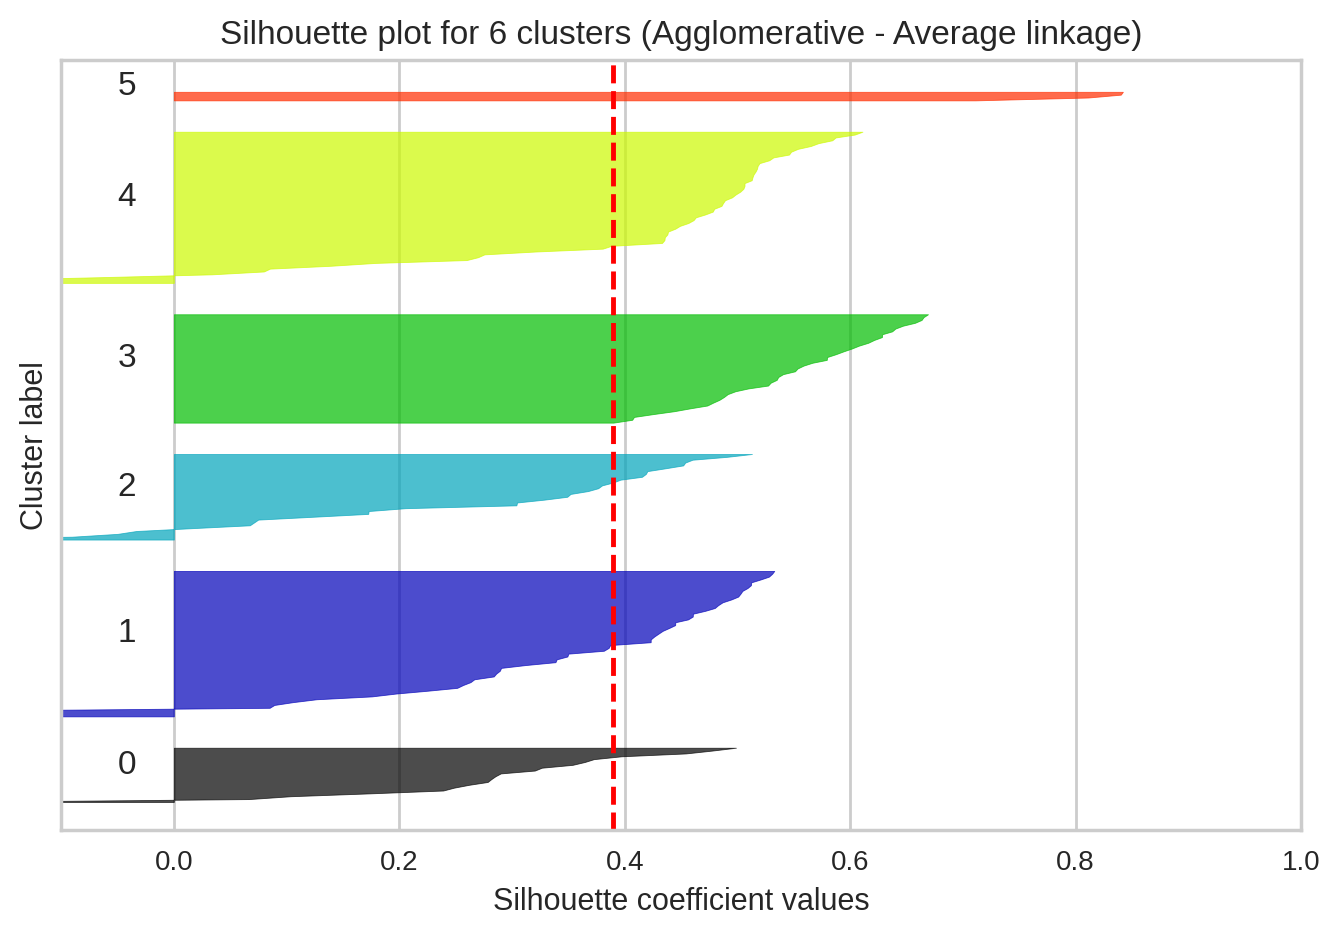

Number of clusters: 7, Average silhouette score: 0.3800


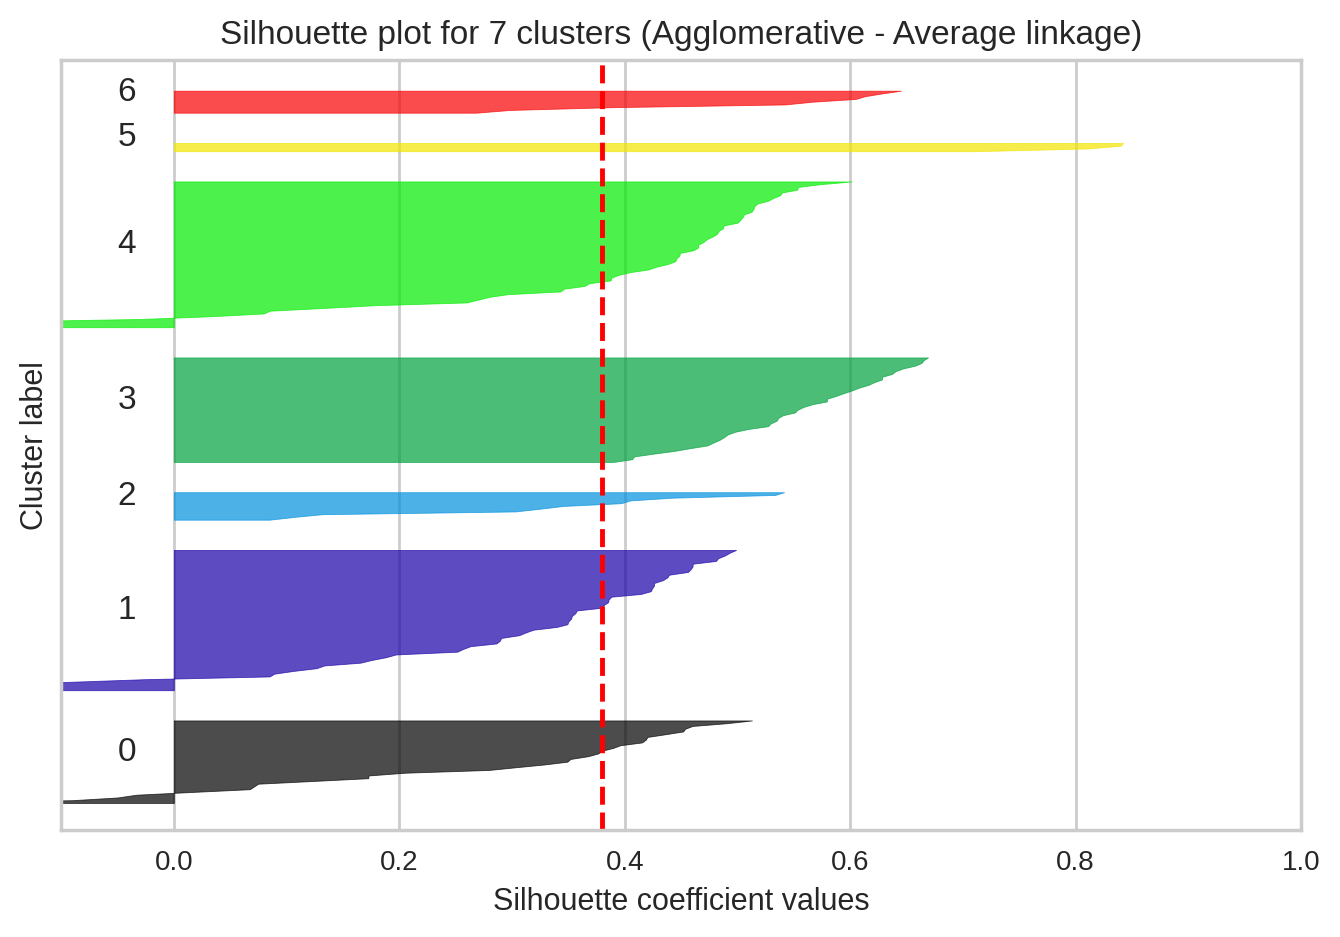

In [12]:
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import silhouette_score, silhouette_samples
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.cm as cm

X = data[numeric_features]
for n_clusters in range(3, 8):
    agglom = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    cluster_labels = agglom.fit_predict(X)

    # Compute silhouette score
    avg_silhouette = silhouette_score(X, cluster_labels)
    print(f"Number of clusters: {n_clusters}, Average silhouette score: {avg_silhouette:.4f}")

    # Silhouette plot setup
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Space between plots

    ax1.set_title(f"Silhouette plot for {n_clusters} clusters (Agglomerative - Average linkage)")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=avg_silhouette, color="red", linestyle="--")
    ax1.set_yticks([])
    plt.show()

**Written Answer:** How many clusters were select based on the Silhouette analysis? Explain your answer.

The optimal number of clusters based on silhouette analysis is 5, because it provides the highest average silhouette score (0.4096), indicating the best balance of cohesion and separation between clusters.

**ANSWER HERE:**

7. Fit the Agglomerative clustering on the scaled data using the optimal number of clusters identified in Q6. Then, visualize the resulting clusters using scatterplots.

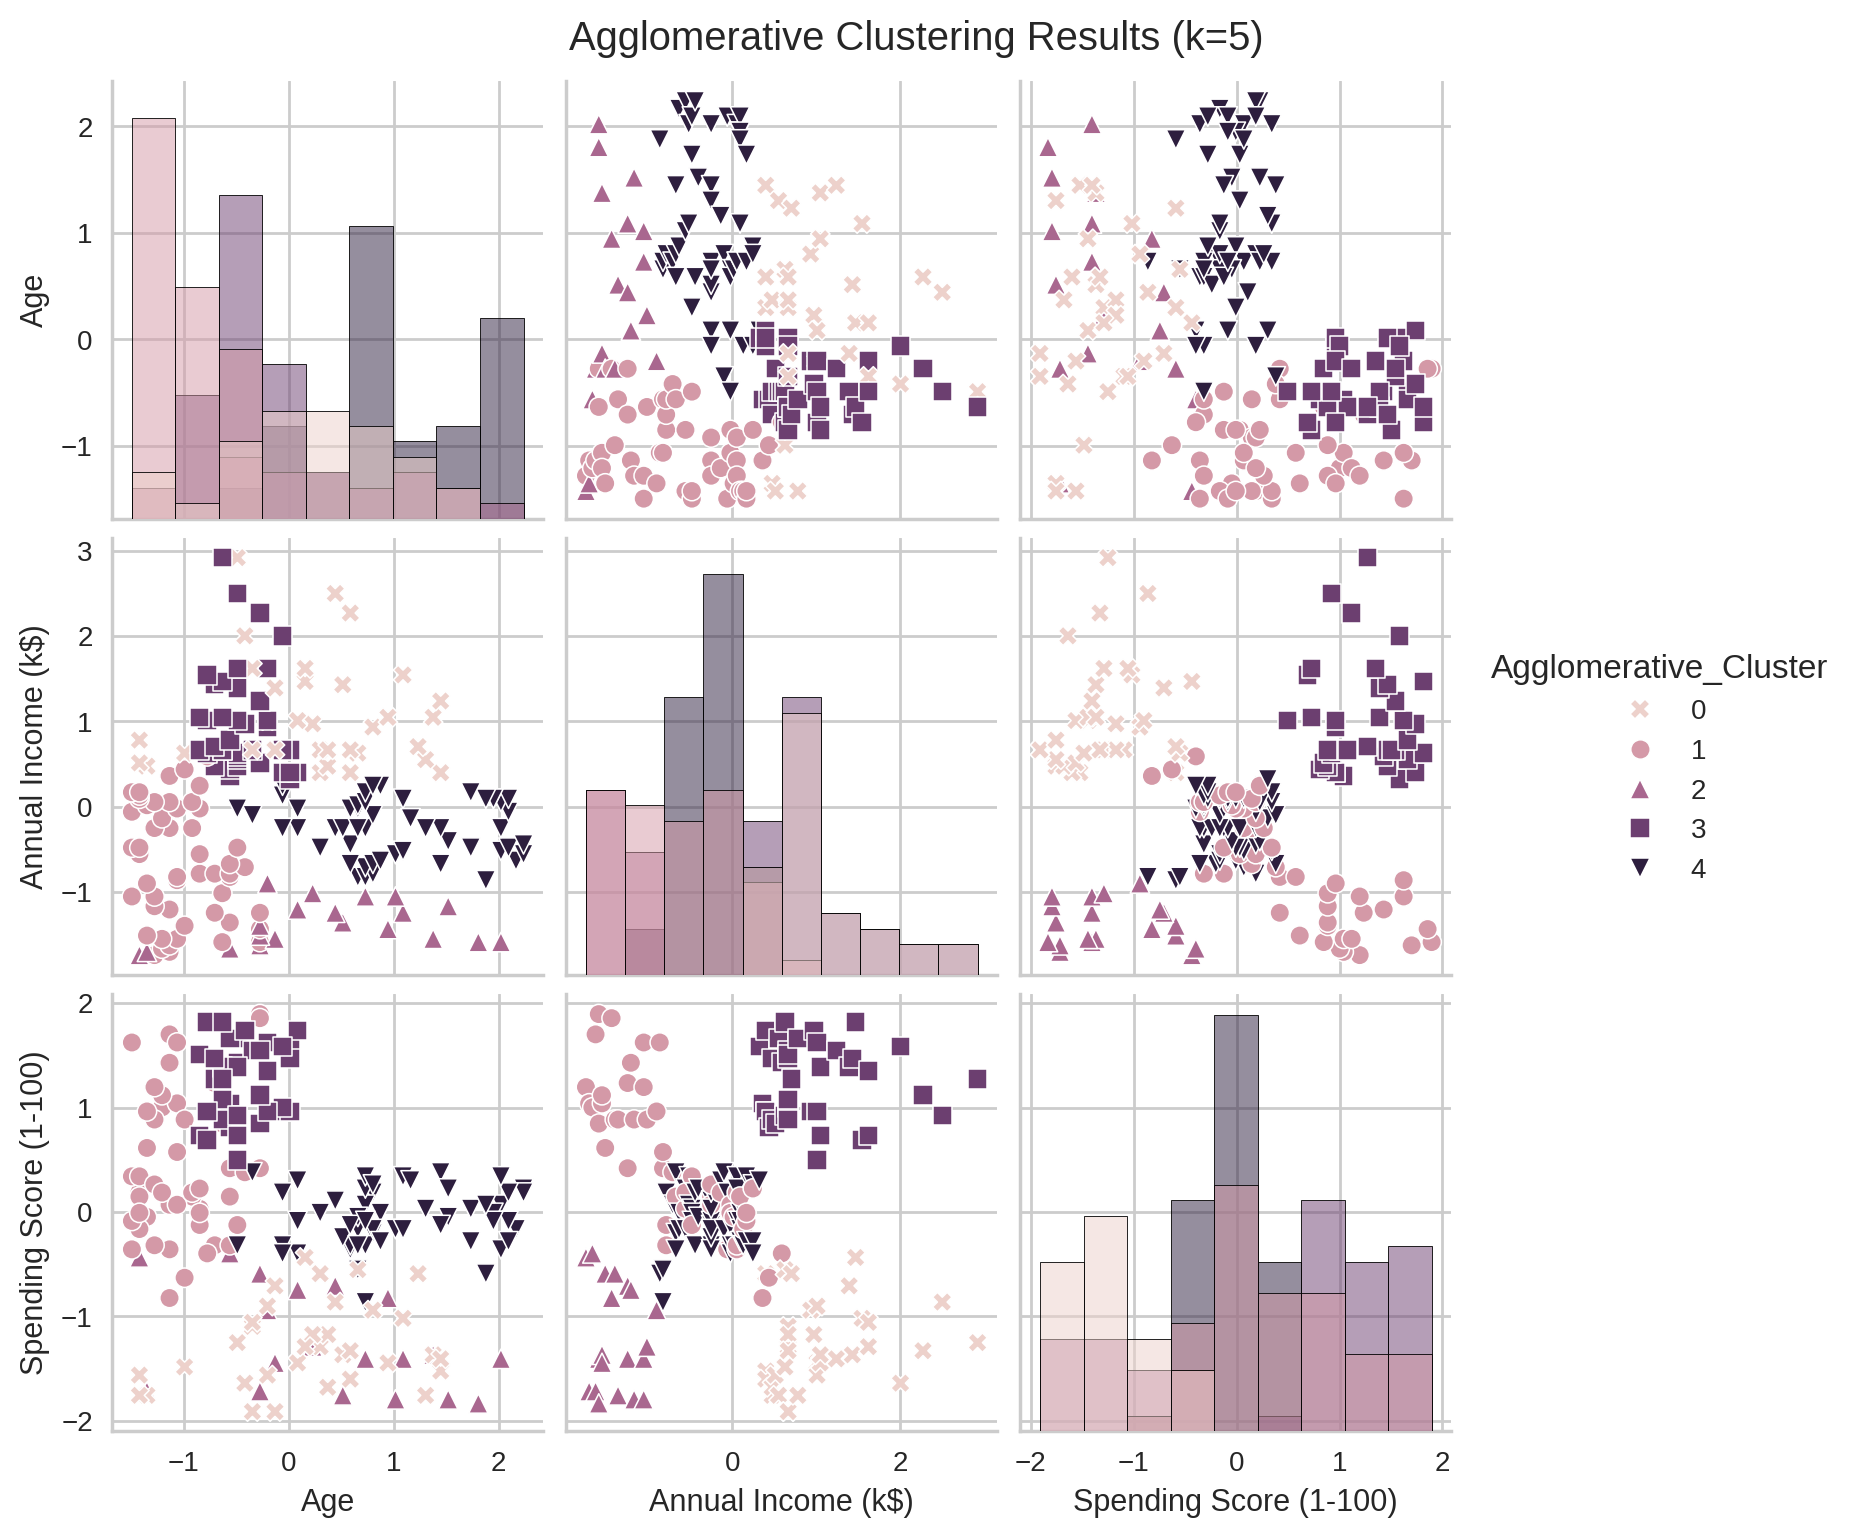

In [13]:
# YOUR CODE HERE
# Fit the Agglomerative Clustering
agglom_5 = AgglomerativeClustering(n_clusters=5, linkage='average')
agglom_labels = agglom_5.fit_predict(data[numeric_features])
# Use with_columns to add the new column to the dataframe 'data'
data = data.with_columns(pl.Series(name="Agglomerative_Cluster", values=agglom_labels))

sns.pairplot(data=data.to_pandas(),
      vars=numeric_features,
      hue="Agglomerative_Cluster", # Use the name of the new column
      markers=['X','o','^','s','v'],
      diag_kind='hist'
      )
plt.suptitle("Agglomerative Clustering Results (k=5)", y=1.02)
plt.show()

8. Using the clusters from Q7, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster.

In [14]:
# YOUR CODE HERE
unscaled_data = unscaled_data.with_columns(pl.Series(name="Agglomerative_Cluster", values=agglom_labels))
unscaled_data.drop("Cluster").to_pandas().groupby("Agglomerative_Cluster").mean()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
Agglomerative_Cluster,,,,
0,164.428571,41.685714,88.228571,17.285714
1,60.269231,24.653846,42.942308,62.076923
2,20.000000,43.900000,24.450000,19.100000
3,162.000000,32.692308,86.538462,82.128205
4,83.203704,53.259259,54.203704,48.555556


**Written answer:**


- Cluster 0: Older, high-income, low spenders
  -  These are wealthy, cautious shoppers who spend very little despite having significant income. Likely conservative or selective buyers who might respond well to premium trust-based offers.

- Cluster 1: Very young, low-to-mid income, relatively high spenders
  - They are likely impulsive or trend-driven shoppers who spend actively despite limited income; ideal candidates for promotions, discounts, and loyalty programs.

- Cluster 2: Older, very low-income, low spenders
  - This is a budget-conscious group that is unlikely to respond to premium offers; better suited to budget deals and value-for-money campaigns.

- Cluster 3: Young-to-middle-aged, high-income, high spenders
  - Most profitable cluster: wealthy and with high spending behavior. They can be targeted with luxury products, exclusive loyalty programs, and personalized services.
  
- Cluster 4: Older, moderate income, moderate spenders
  - Likely stable, conservative shoppers who value reliability and consistency. They may respond to trust-based and loyalty-driven marketing.

## Spectral Clustering

9. Use Spectral Clustering to determine the best number of clusters (between 3 and 8) using silhouette analysis.

Set the parameters:
- `affinity = 'nearest_neighbors'`
- `n_jobs = -1`
- `n_neighbors = 10`
- `random_state = 2025`


For each number of clusters:

- Compute and display the average silhouette score
- Generate the silhouette plot.



Number of clusters: 3, Average silhouette score: 0.3496


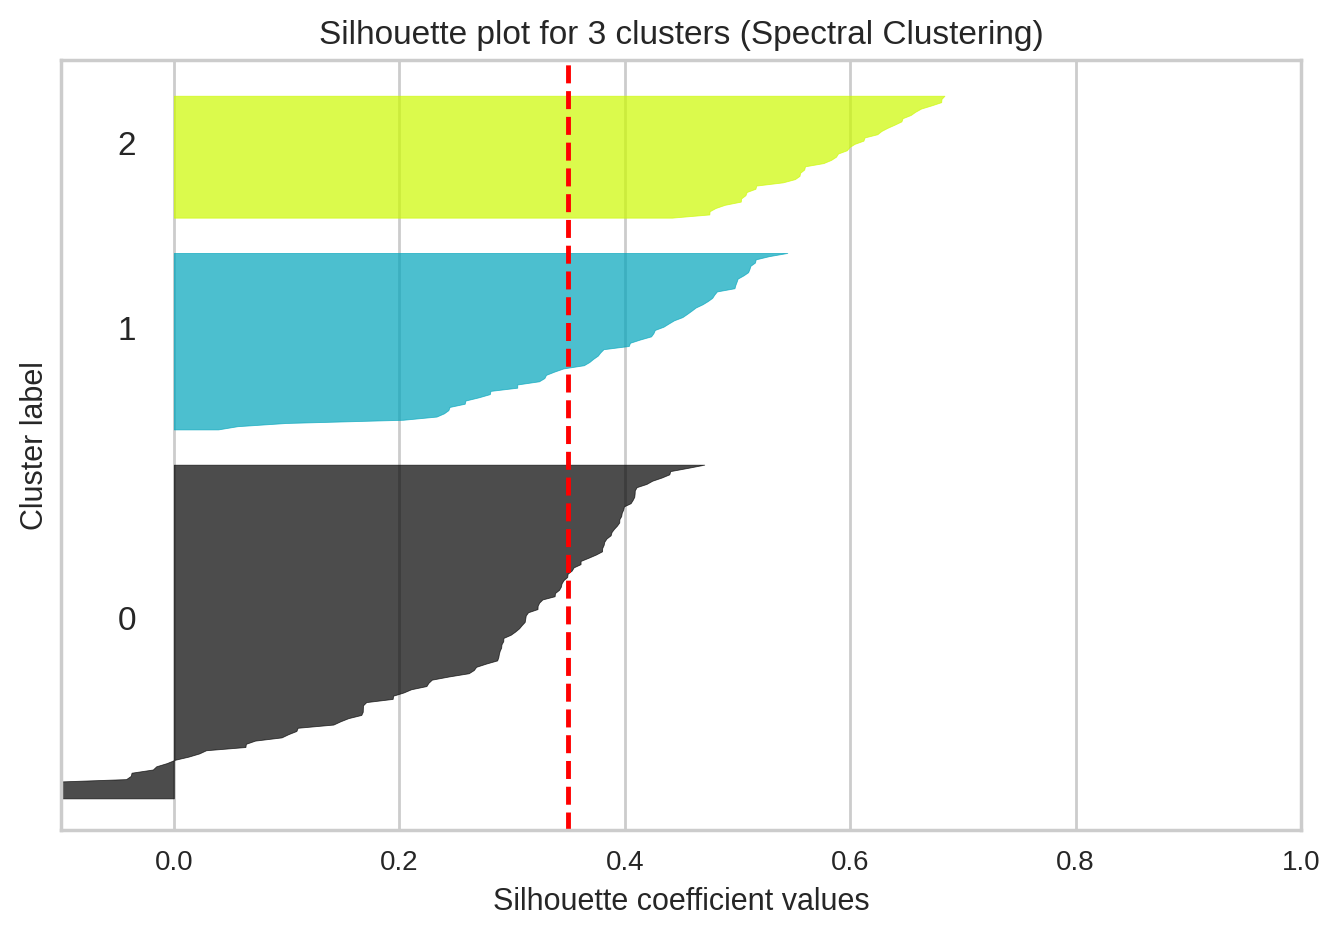

Number of clusters: 4, Average silhouette score: 0.3978


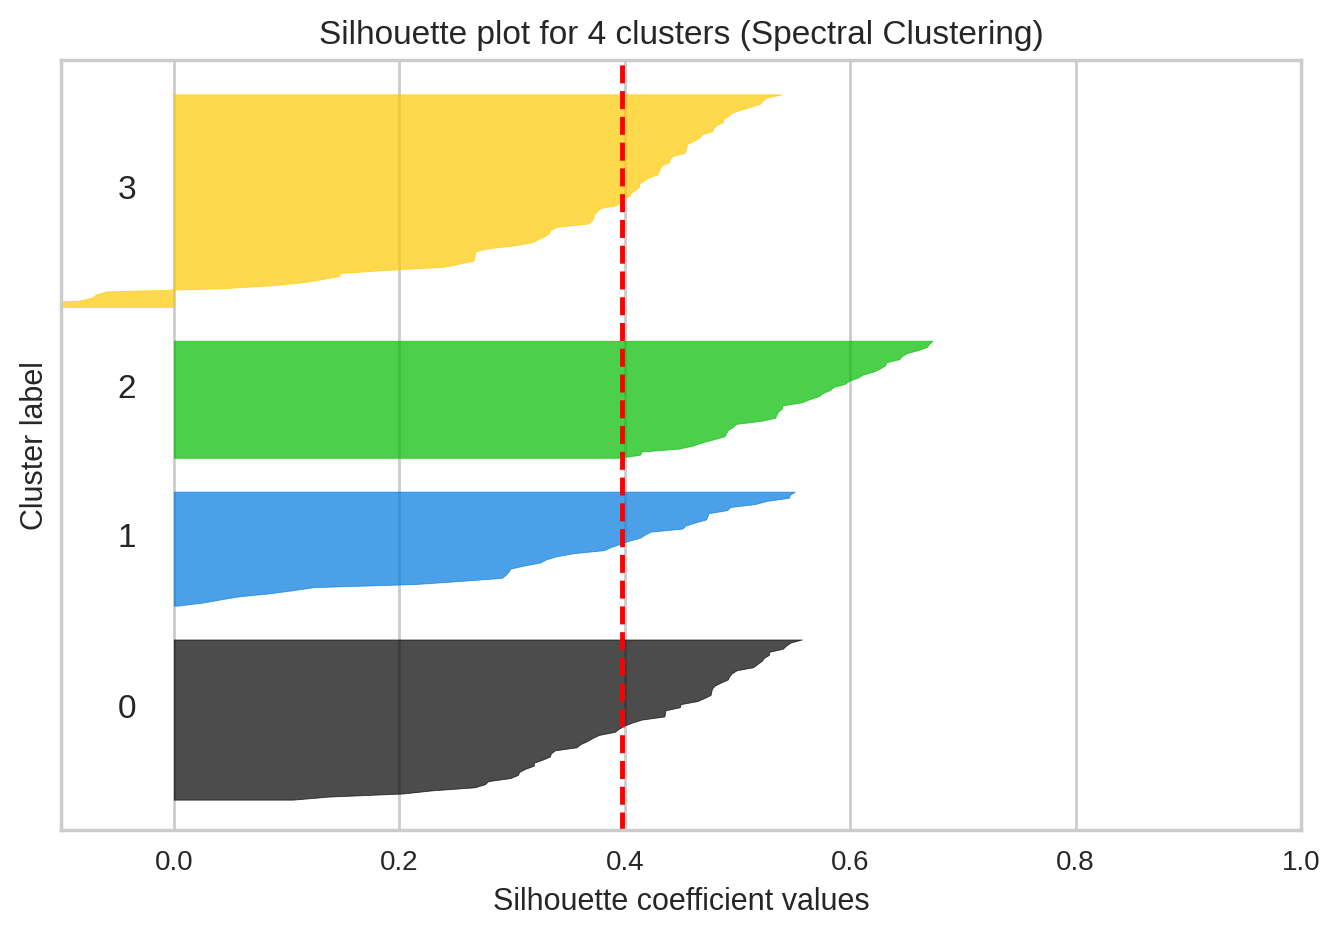

Number of clusters: 5, Average silhouette score: 0.3734


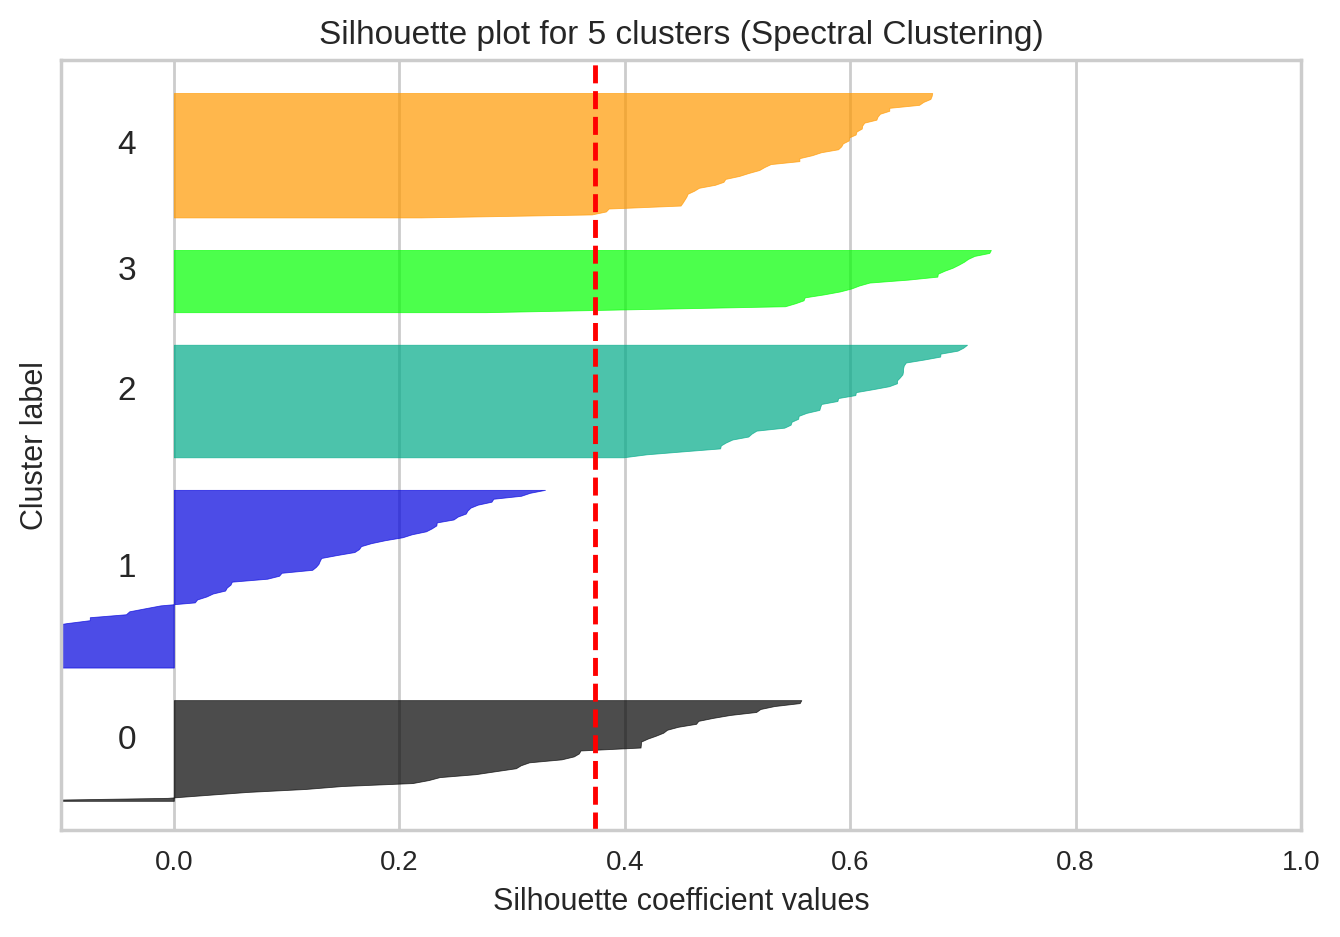

Number of clusters: 6, Average silhouette score: 0.4181


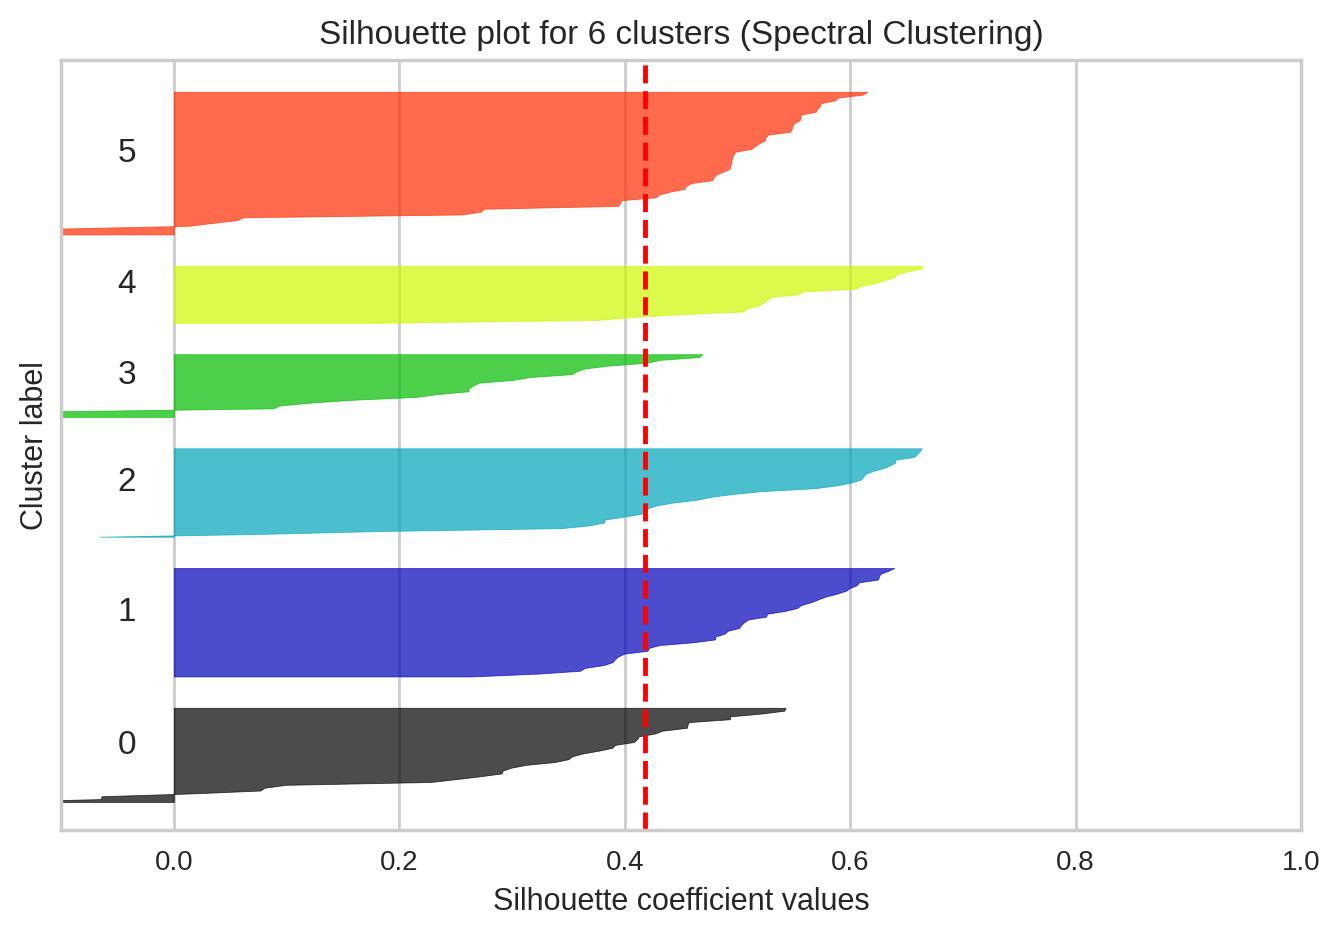

Number of clusters: 7, Average silhouette score: 0.4148


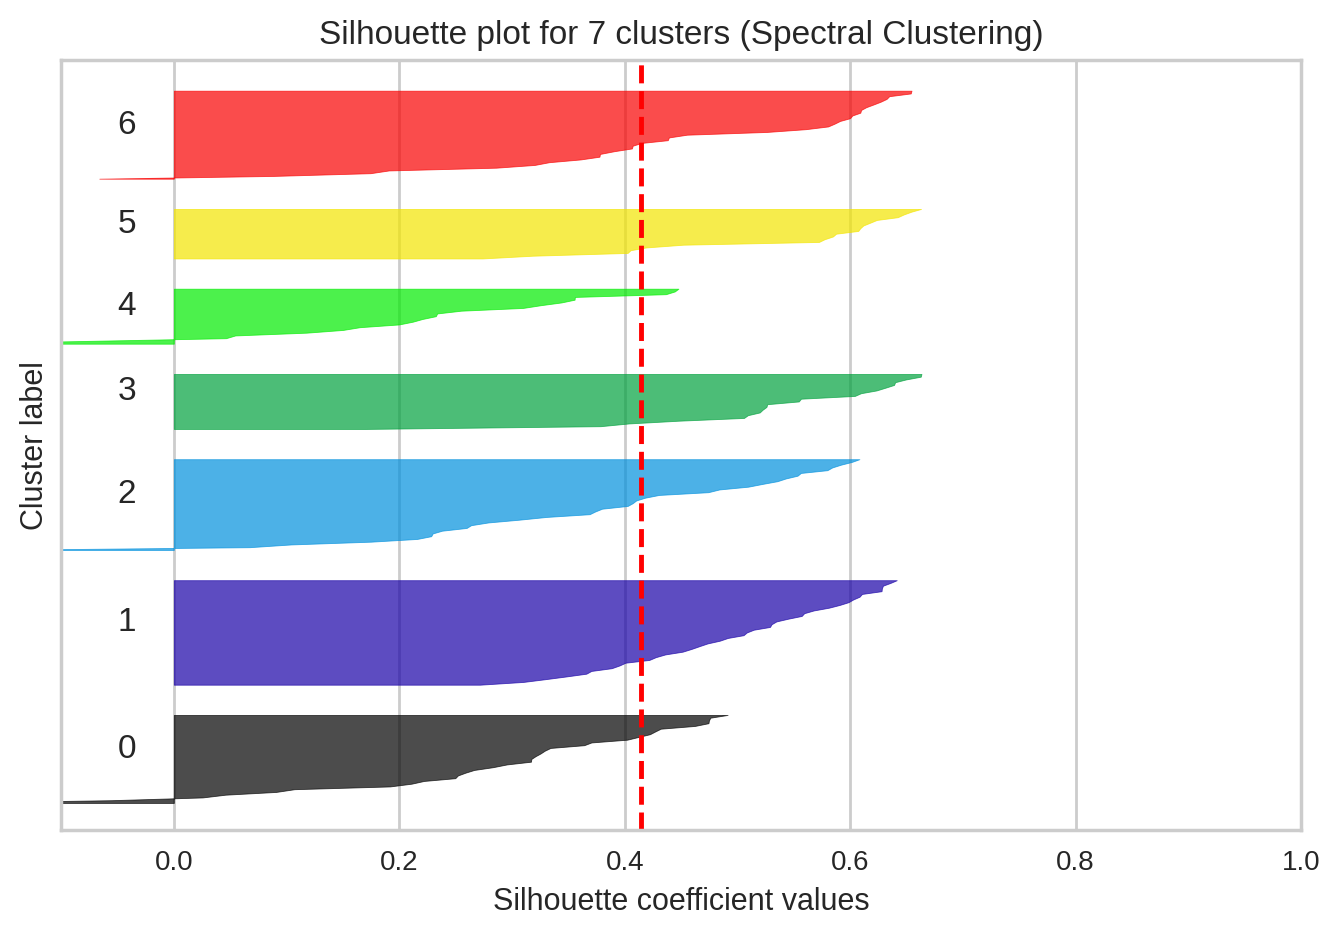

Number of clusters: 8, Average silhouette score: 0.3777


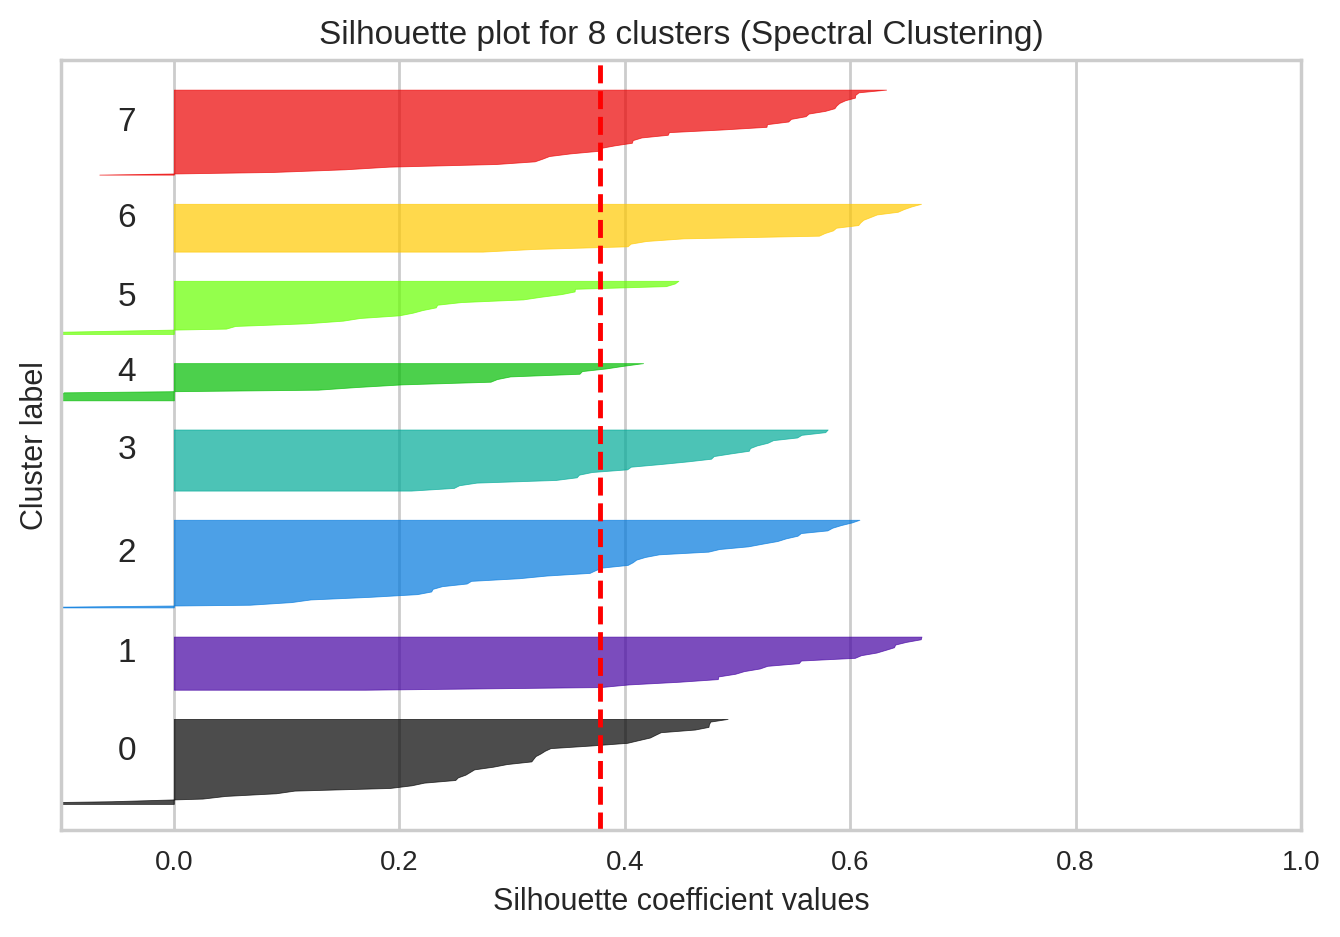

In [15]:
# YOUR CODE HERE
for n_clusters in range(3, 9):
    # Fit Spectral Clustering model
    spectral = SpectralClustering(
        n_clusters=n_clusters,
        affinity='nearest_neighbors',
        n_neighbors=10,
        n_jobs=-1,
        random_state=2025,
        assign_labels='kmeans'  # best practice to use k-means-based assignment
    )
    cluster_labels = spectral.fit_predict(X)

    # Compute silhouette score
    avg_silhouette = silhouette_score(X, cluster_labels)
    print(f"Number of clusters: {n_clusters}, Average silhouette score: {avg_silhouette:.4f}")

    # Compute silhouette values for individual samples
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # Plot silhouette diagram
    y_lower = 10
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # space between clusters

    ax1.axvline(x=avg_silhouette, color="red", linestyle="--")
    ax1.set_title(f"Silhouette plot for {n_clusters} clusters (Spectral Clustering)")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])
    plt.show()


**Written Answer:** How many clusters were select based on the Silhouette analysis? Explain your answer.

The optimal number of clusters based on silhouette analysis is 6, because it provides the highest average silhouette score (0.4181), indicating the best balance of cohesion and separation between clusters.

**Written answer:**

10. Fit a Spectral Clustering on the scaled data using the optimal number of clusters identified in Q9. Then, visualize the resulting clusters using scatterplots.

In [16]:
# YOUR CODE HERE
spectral_model = SpectralClustering(n_clusters=6,  # Number of clusters to train.
                   assign_labels='cluster_qr',
                   affinity='nearest_neighbors',
                   n_jobs=-1,
                   n_neighbors=10,
                   random_state=20250314)

# Let's create a pipeline
spectral_pipe = Pipeline([('scale', StandardScaler()),
              ('spectral', spectral_model)
             ])

# Fit the model and get the labels
# Use 'with_columns' to add the new column instead of direct assignment
spectual_cluster_labels = spectral_pipe.fit_predict(X) # Fit and predict using your pipeline
data = data.with_columns(pl.Series(name="spectual_cluster", values=spectual_cluster_labels)) # Use with_columns to add the new column

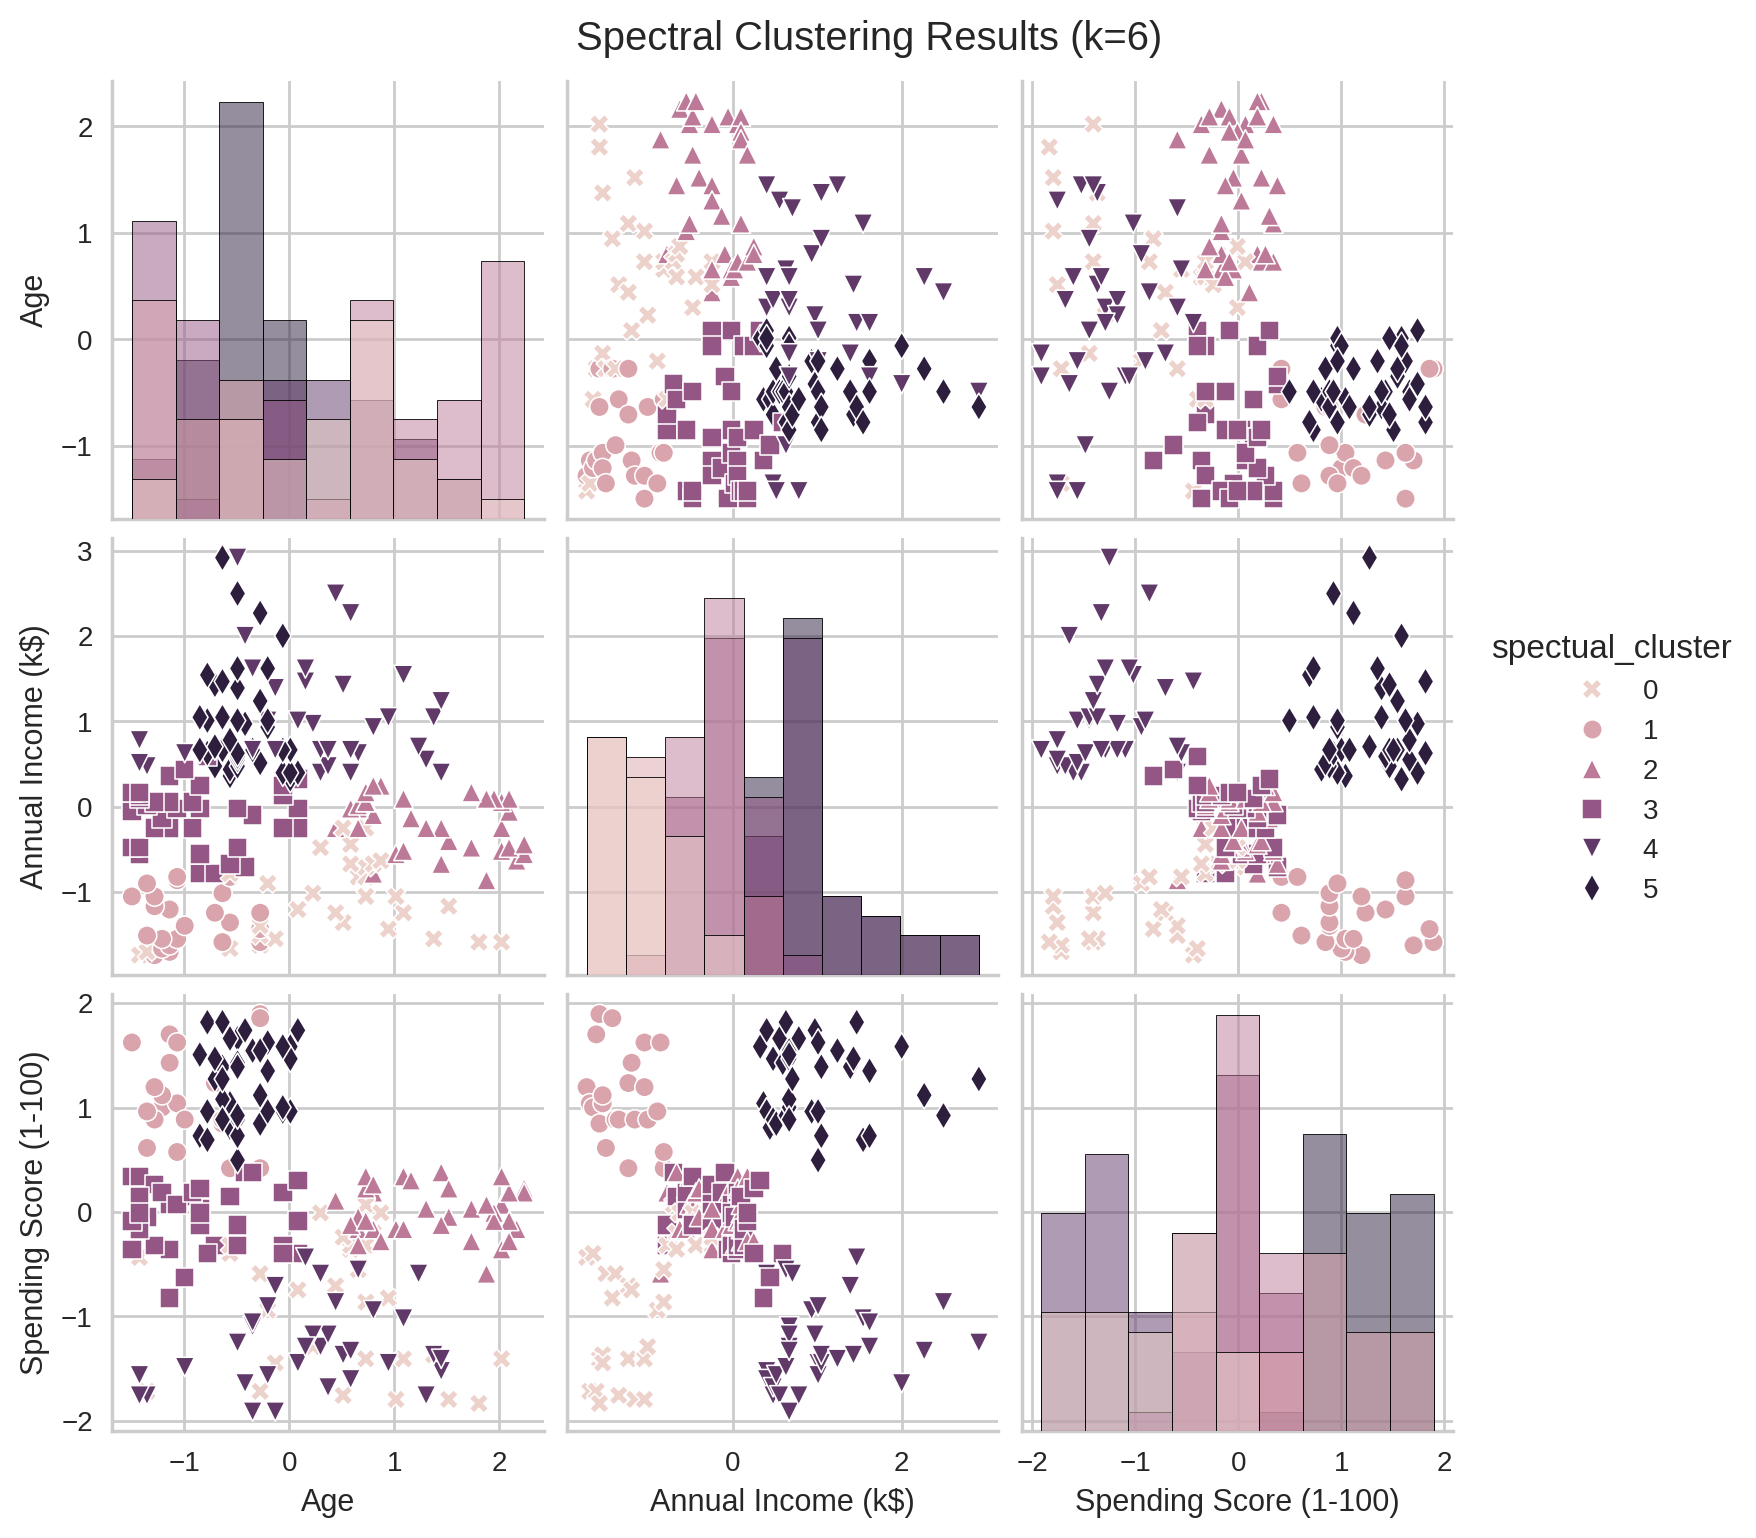

In [17]:
sns.pairplot(
    data=data.to_pandas(),
    vars=numeric_features,
    hue="spectual_cluster",
    markers=['X','o','^','s','v','d'],
    diag_kind="hist",
)
plt.suptitle("Spectral Clustering Results (k=6)", y=1.02)
plt.show()

11. Using the clusters from Q10, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster.

In [18]:
# YOUR CODE HERE
unscaled_data = unscaled_data.with_columns(pl.Series(name="spectual_cluster", values=spectual_cluster_labels))
unscaled_data.drop("Cluster").drop("Agglomerative_Cluster").to_pandas().groupby("spectual_cluster").mean()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
spectual_cluster,,,,
0,34.193548,44.774194,31.741935,27.548387
1,24.000000,25.521739,26.304348,78.565217
2,85.750000,58.250000,55.166667,50.194444
3,92.444444,26.777778,57.611111,49.000000
4,164.428571,41.685714,88.228571,17.285714
5,162.000000,32.692308,86.538462,82.128205


**Written answer:**


- Cluster 0: Older, low-income, low spenders
  -  These customers are price-sensitive and spend cautiously. They are less likely to respond to premium offers; instead, they may be targeted with value-based deals and loyalty incentives

- Cluster 1: Very young, low-income, high spenders
  - Likely impulsive buyers who spend a lot relative to their income. This group can be targeted with promotions, seasonal discounts, and loyalty programs.

- Cluster 2: Older, moderate income, moderate spenders
  - Possibly stable and conservative buyers who are reliable but not extravagant. Trust-based and senior-oriented marketing may work well here.

- Cluster 3: Young, moderate-income, moderate spenders
  - This cluster of customers may be influenced by lifestyle marketing, social media campaigns, and aspirational products.

- Cluster 4: Older, high-income, very low spenders
  - Wealthy but cautious and conservative with spending. They may require premium trust-based offers or highly personalized service to increase engagement.

- Cluster 5: Young-to-middle-aged, high-income
  - This is the most profitable cluster and we can target them with exclusive luxury products, premium loyalty programs, and high-end personalized marketing.

12. Compare the results obtained using the Agglomerative Clustering and the Spectral Clustering methods. Comment your findings.

**Written answer:**

Both clustering methods are able capture the following groups:
- Older, high-income, low spenders
- Young, low-income, high spenders
- Older, low-income, low spenders
- High-income, high spenders
- Moderate income, moderate spenders

However, spectral clustering is able to capture an additional cluster:
- Younger, moderate-income, moderate spenders

Besides, in terms of the silhouette scores:
- Agglomerative Clustering: 0.4096 (k=5)
- Spectral clustering: 0.4181 (k=6)

It thus indicates that spectral clustering captured more natural group separations, especially for non-linear patterns.